# Initial configuration

In [1]:
%load_ext autoreload
%autoreload 2

import os
os.chdir("/nfs/turbo/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl")
from travel import init_travel
init_travel()

In [2]:
import torch
from transformers import AutoModelForVision2Seq, AutoProcessor, BitsAndBytesConfig

VLM_NAME = "llava-hf/llava-1.5-7b-hf"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    llm_int8_threshold=6.0,
    llm_int8_has_fp16_weight=False,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
)

vlm = AutoModelForVision2Seq.from_pretrained(VLM_NAME, 
                                            quantization_config=bnb_config)
vlm.language_model.generation_config.temperature = None
vlm.language_model.generation_config.top_p = None
vlm.language_model.generation_config.do_sample = False

vlm_processor = AutoProcessor.from_pretrained(VLM_NAME)
vlm_processor.tokenizer.padding_side = "left"

visual_filter = None

/home/sstorks/.cache/pypoetry/virtualenvs/travel-nQET-zRt-py3.10/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/sstorks/.cache/pypoetry/virtualenvs/travel-nQET-zRt-py3.10/lib/python3.10/site-packages/transformers/models/llava/configuration_llava.py:104: FutureWarning: The `vocab_size` argument is deprecated and will be removed in v4.42, since it can be inferred from the `text_config`. Passing this argument has no effect
  warnings.warn(
`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Optional: set up visual filter

In [33]:
from PIL import Image
import spacy
import torch
from travel.model.grounding import SpatialVisualFilter, ImageMaskTypes, ContrastiveRegionFilter

# visual_filter = SpatialVisualFilter(rephrase_questions=False, mask_strength=40.0, mask_type=ImageMaskTypes.Blur, device="cuda:0")
visual_filter = ContrastiveRegionFilter(device="cuda:0", mask_strength=100.0, mask_type=ImageMaskTypes.Blur)
nlp = spacy.load('en_core_web_lg')

`low_cpu_mem_usage` was None, now set to True since model is quantized.


# Run VQA with yes-no questions

In [30]:
from PIL import Image

from travel.data.vqa import VQG2VQA_PROMPT_TEMPLATES, get_vqa_response_token_ids

# Kitchen tap examples
# questions = ["Do you see the tap in the image?", 
#              "Do you see the tap in the image?", 
#              "Is there lettuce on the stove?",
#              "Look at the stove. Is there lettuce on the stove?",
#              "Is the tap turned on?",
#             "Are there cherry tomatoes in the bowl?",
#             "Look in the bowl. Are there any cherry tomatoes in the bowl?",
#             "Are there cherry tomatoes in the bowl?",
#             "Look in the bowl. Are there any cherry tomatoes in the bowl?",]
# frames = [Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition4of4/1ab9d5f7-0181-458e-a5e7-72ce87501f3e/38/pos/frames/frame_1ab9d5f7-0181-458e-a5e7-72ce87501f3e-38-pos_0.jpg"),
#           Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition4of4/1ab9d5f7-0181-458e-a5e7-72ce87501f3e/38/pos/frames/frame_1ab9d5f7-0181-458e-a5e7-72ce87501f3e-38-pos_0.jpg"),
#           Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition4of4/1ab9d5f7-0181-458e-a5e7-72ce87501f3e/38/pos/frames/frame_1ab9d5f7-0181-458e-a5e7-72ce87501f3e-38-pos_0.jpg"),
#          Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition3of4/90093217-6a61-48ce-b737-e581499cf491/48/pos/frames/frame_90093217-6a61-48ce-b737-e581499cf491-48-pos_4.jpg"),
#          Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition3of4/90093217-6a61-48ce-b737-e581499cf491/48/pos/frames/frame_90093217-6a61-48ce-b737-e581499cf491-48-pos_4.jpg"),
#           Image.open("demo_images/demo_frame0.png").convert("RGB"),
#           Image.open("demo_images/demo_frame0.png").convert("RGB"),
#           Image.open("demo_images/demo_frame2.png").convert("RGB"),
#           Image.open("demo_images/demo_frame2.png").convert("RGB"),
#          ]

# Glue tube and drawer examples
# questions = [
#     "Is there a glue tube in the drawer?",
#     "Is there a glue tube in someone's hand?",
#     "Are the floorboards connected?",
#     "Is there a hammer in someone's hand?",
#     "Do you see a glue tube in the image?",
#     "Do you see a drawer in the image?",
#     'The instructions say to "hammer the floorboards". Do you see someone working on this?',
#     'The instructions say to "take the glue tube from the drawer". Do you see someone working on this?'
# ]
# frames = [
#     Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition3of4/da32ff6e-27b2-47e6-b38f-dbf7a36b5f4d/70/easyneg_MisalignSRL_V_ARG1_898afb02-0bde-4fe7-81f8-645b94ac4899_4034.461679999999/frames/frame_da32ff6e-27b2-47e6-b38f-dbf7a36b5f4d-70-easyneg_MisalignSRL_V_ARG1_898afb02-0bde-4fe7-81f8-645b94ac4899_4034.461679999999_3.jpg"),
#     Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition3of4/da32ff6e-27b2-47e6-b38f-dbf7a36b5f4d/70/easyneg_MisalignSRL_V_ARG1_898afb02-0bde-4fe7-81f8-645b94ac4899_4034.461679999999/frames/frame_da32ff6e-27b2-47e6-b38f-dbf7a36b5f4d-70-easyneg_MisalignSRL_V_ARG1_898afb02-0bde-4fe7-81f8-645b94ac4899_4034.461679999999_3.jpg"),
#     Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition3of4/da32ff6e-27b2-47e6-b38f-dbf7a36b5f4d/70/easyneg_MisalignSRL_V_ARG1_898afb02-0bde-4fe7-81f8-645b94ac4899_4034.461679999999/frames/frame_da32ff6e-27b2-47e6-b38f-dbf7a36b5f4d-70-easyneg_MisalignSRL_V_ARG1_898afb02-0bde-4fe7-81f8-645b94ac4899_4034.461679999999_3.jpg"),
#     Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition3of4/da32ff6e-27b2-47e6-b38f-dbf7a36b5f4d/70/easyneg_MisalignSRL_V_ARG1_898afb02-0bde-4fe7-81f8-645b94ac4899_4034.461679999999/frames/frame_da32ff6e-27b2-47e6-b38f-dbf7a36b5f4d-70-easyneg_MisalignSRL_V_ARG1_898afb02-0bde-4fe7-81f8-645b94ac4899_4034.461679999999_3.jpg"),
#     Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition3of4/da32ff6e-27b2-47e6-b38f-dbf7a36b5f4d/70/easyneg_MisalignSRL_V_ARG1_898afb02-0bde-4fe7-81f8-645b94ac4899_4034.461679999999/frames/frame_da32ff6e-27b2-47e6-b38f-dbf7a36b5f4d-70-easyneg_MisalignSRL_V_ARG1_898afb02-0bde-4fe7-81f8-645b94ac4899_4034.461679999999_3.jpg"),
#     Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition3of4/da32ff6e-27b2-47e6-b38f-dbf7a36b5f4d/70/easyneg_MisalignSRL_V_ARG1_898afb02-0bde-4fe7-81f8-645b94ac4899_4034.461679999999/frames/frame_da32ff6e-27b2-47e6-b38f-dbf7a36b5f4d-70-easyneg_MisalignSRL_V_ARG1_898afb02-0bde-4fe7-81f8-645b94ac4899_4034.461679999999_3.jpg"),
#     Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition3of4/da32ff6e-27b2-47e6-b38f-dbf7a36b5f4d/70/easyneg_MisalignSRL_V_ARG1_898afb02-0bde-4fe7-81f8-645b94ac4899_4034.461679999999/frames/frame_da32ff6e-27b2-47e6-b38f-dbf7a36b5f4d-70-easyneg_MisalignSRL_V_ARG1_898afb02-0bde-4fe7-81f8-645b94ac4899_4034.461679999999_3.jpg"),    
#     Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition3of4/da32ff6e-27b2-47e6-b38f-dbf7a36b5f4d/70/easyneg_MisalignSRL_V_ARG1_898afb02-0bde-4fe7-81f8-645b94ac4899_4034.461679999999/frames/frame_da32ff6e-27b2-47e6-b38f-dbf7a36b5f4d-70-easyneg_MisalignSRL_V_ARG1_898afb02-0bde-4fe7-81f8-645b94ac4899_4034.461679999999_3.jpg"),    
# ]

# # Thread and bag examples
# questions = [
#     "Is the thread in someone's hand?",
#     "Is the thread in the bag?",
#     "Do you see a thread in the image?",
#     "Do you see a bag in the image?",
#     'The instructions say to "Pick up the thread". Do you see someone working on this?',
#     'The instructions say to "Continue cutting the chicken". Do you see someone working on this?',
# ]
# frames = [
#     Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition1of4/79c62f24-488e-4a69-8220-3b20cb4bf72b/398/easyneg_MisalignSRL_V_ARG1_c8f8ebf1-5613-4f4a-802c-ada5e4c4b651_326.6214286/frames/frame_79c62f24-488e-4a69-8220-3b20cb4bf72b-398-easyneg_MisalignSRL_V_ARG1_c8f8ebf1-5613-4f4a-802c-ada5e4c4b651_326.6214286_3.jpg"),
#     Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition1of4/79c62f24-488e-4a69-8220-3b20cb4bf72b/398/easyneg_MisalignSRL_V_ARG1_c8f8ebf1-5613-4f4a-802c-ada5e4c4b651_326.6214286/frames/frame_79c62f24-488e-4a69-8220-3b20cb4bf72b-398-easyneg_MisalignSRL_V_ARG1_c8f8ebf1-5613-4f4a-802c-ada5e4c4b651_326.6214286_3.jpg"),    
#     Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition1of4/79c62f24-488e-4a69-8220-3b20cb4bf72b/398/easyneg_MisalignSRL_V_ARG1_c8f8ebf1-5613-4f4a-802c-ada5e4c4b651_326.6214286/frames/frame_79c62f24-488e-4a69-8220-3b20cb4bf72b-398-easyneg_MisalignSRL_V_ARG1_c8f8ebf1-5613-4f4a-802c-ada5e4c4b651_326.6214286_3.jpg"),    
#     Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition1of4/79c62f24-488e-4a69-8220-3b20cb4bf72b/398/easyneg_MisalignSRL_V_ARG1_c8f8ebf1-5613-4f4a-802c-ada5e4c4b651_326.6214286/frames/frame_79c62f24-488e-4a69-8220-3b20cb4bf72b-398-easyneg_MisalignSRL_V_ARG1_c8f8ebf1-5613-4f4a-802c-ada5e4c4b651_326.6214286_3.jpg"),    
#     Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition1of4/79c62f24-488e-4a69-8220-3b20cb4bf72b/398/easyneg_MisalignSRL_V_ARG1_c8f8ebf1-5613-4f4a-802c-ada5e4c4b651_326.6214286/frames/frame_79c62f24-488e-4a69-8220-3b20cb4bf72b-398-easyneg_MisalignSRL_V_ARG1_c8f8ebf1-5613-4f4a-802c-ada5e4c4b651_326.6214286_3.jpg"),    
#     Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition1of4/79c62f24-488e-4a69-8220-3b20cb4bf72b/398/easyneg_MisalignSRL_V_ARG1_c8f8ebf1-5613-4f4a-802c-ada5e4c4b651_326.6214286/frames/frame_79c62f24-488e-4a69-8220-3b20cb4bf72b-398-easyneg_MisalignSRL_V_ARG1_c8f8ebf1-5613-4f4a-802c-ada5e4c4b651_326.6214286_3.jpg"),    
# ]

# Brush and wall examples
questions = [
    "Is the brush on the wall?",
    "Is the brush in someone's hand?",
    "Do you see a brush in the image?",
    "Do you see a wall in the image?",
    'The instructions say to "Rub the brush on the wall". Do you see someone working on this?',
    'The instructions say to "Rub the clippers on the towel". Do you see someone working on this?',
]
frames = [
    Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition1of4/5b97f47f-f015-46f3-8879-3fcc2a61a728/177/easyneg_MisalignSRL_ARG1_2dbdd409-0be0-447c-8ae8-3f107fe9af80_152.6393286/frames/frame_5b97f47f-f015-46f3-8879-3fcc2a61a728-177-easyneg_MisalignSRL_ARG1_2dbdd409-0be0-447c-8ae8-3f107fe9af80_152.6393286_1.jpg"),
    Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition1of4/5b97f47f-f015-46f3-8879-3fcc2a61a728/177/easyneg_MisalignSRL_ARG1_2dbdd409-0be0-447c-8ae8-3f107fe9af80_152.6393286/frames/frame_5b97f47f-f015-46f3-8879-3fcc2a61a728-177-easyneg_MisalignSRL_ARG1_2dbdd409-0be0-447c-8ae8-3f107fe9af80_152.6393286_1.jpg"),
    Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition1of4/5b97f47f-f015-46f3-8879-3fcc2a61a728/177/easyneg_MisalignSRL_ARG1_2dbdd409-0be0-447c-8ae8-3f107fe9af80_152.6393286/frames/frame_5b97f47f-f015-46f3-8879-3fcc2a61a728-177-easyneg_MisalignSRL_ARG1_2dbdd409-0be0-447c-8ae8-3f107fe9af80_152.6393286_1.jpg"),
    Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition1of4/5b97f47f-f015-46f3-8879-3fcc2a61a728/177/easyneg_MisalignSRL_ARG1_2dbdd409-0be0-447c-8ae8-3f107fe9af80_152.6393286/frames/frame_5b97f47f-f015-46f3-8879-3fcc2a61a728-177-easyneg_MisalignSRL_ARG1_2dbdd409-0be0-447c-8ae8-3f107fe9af80_152.6393286_1.jpg"),
    Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition1of4/5b97f47f-f015-46f3-8879-3fcc2a61a728/177/easyneg_MisalignSRL_ARG1_2dbdd409-0be0-447c-8ae8-3f107fe9af80_152.6393286/frames/frame_5b97f47f-f015-46f3-8879-3fcc2a61a728-177-easyneg_MisalignSRL_ARG1_2dbdd409-0be0-447c-8ae8-3f107fe9af80_152.6393286_1.jpg"),
    Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition1of4/5b97f47f-f015-46f3-8879-3fcc2a61a728/177/easyneg_MisalignSRL_ARG1_2dbdd409-0be0-447c-8ae8-3f107fe9af80_152.6393286/frames/frame_5b97f47f-f015-46f3-8879-3fcc2a61a728-177-easyneg_MisalignSRL_ARG1_2dbdd409-0be0-447c-8ae8-3f107fe9af80_152.6393286_1.jpg"),
]


prompts = [VQG2VQA_PROMPT_TEMPLATES[type(vlm)].format(question=question) for question in questions]

response_token_ids = get_vqa_response_token_ids(vlm_processor.tokenizer)

frames_distorted = None

Optional: corrupt images with noise

In [31]:
import numpy as np
from PIL import Image

def add_diffusion_noise(image: Image.Image, noise_step: int) -> Image.Image:
    """
    Add diffusion noise to a PIL Image.
    
    Parameters:
    - image (PIL.Image.Image): The input image to which noise will be added.
    - noise_step (int): The diffusion step to determine the noise level.
    
    Returns:
    - PIL.Image.Image: The image with added diffusion noise.
    """
    
    # Convert the image to a NumPy array and then to a PyTorch tensor
    image_array = np.array(image).astype(np.float32) / 255.0
    image_tensor = torch.tensor(image_array).permute(2, 0, 1).unsqueeze(0)  # Shape: (1, C, H, W)

    num_steps = 1000  # Number of diffusion steps

    # Decide beta in each step
    betas = torch.linspace(-6, 6, num_steps)
    betas = torch.sigmoid(betas) * (0.5e-2 - 1e-5) + 1e-5

    # Decide alphas in each step
    alphas = 1 - betas
    alphas_prod = torch.cumprod(alphas, dim=0)
    alphas_prod_p = torch.cat([torch.tensor([1.0]), alphas_prod[:-1]], 0)  # p for previous
    alphas_bar_sqrt = torch.sqrt(alphas_prod)
    one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

    def q_x(x_0, t):
        noise = torch.randn_like(x_0)
        alphas_t = alphas_bar_sqrt[t]
        alphas_1_m_t = one_minus_alphas_bar_sqrt[t]
        return alphas_t * x_0 + alphas_1_m_t * noise

    # Apply noise at the specified noise step
    noisy_image_tensor = q_x(image_tensor, noise_step).squeeze(0).permute(1, 2, 0)  # Shape: (H, W, C)

    # Convert the noisy image tensor back to a NumPy array
    noisy_image_array = (noisy_image_tensor.numpy() * 255.0).clip(0, 255).astype(np.uint8)

    # Convert the NumPy array back to a PIL Image
    noisy_image = Image.fromarray(noisy_image_array)

    return noisy_image

def add_gaussian_noise(image: Image.Image, mean: float=0.0, std_dev: float=25.0) -> Image.Image:
    """
    Add Gaussian noise to a PIL Image.
    
    Parameters:
    - image (PIL.Image.Image): The input image to which noise will be added.
    - mean (float): The mean of the Gaussian noise.
    - std_dev (float): The standard deviation of the Gaussian noise.
    
    Returns:
    - PIL.Image.Image: The image with added Gaussian noise.
    """
    
    # Convert the image to a NumPy array
    image_array = np.array(image)
    
    # Generate Gaussian noise
    noise = np.random.normal(mean, std_dev, image_array.shape)
    
    # Add the Gaussian noise to the image
    noisy_image_array = image_array + noise
    
    # Clip the values to be in the valid range [0, 255] and convert to uint8
    noisy_image_array = np.clip(noisy_image_array, 0, 255).astype(np.uint8)
    
    # Convert the noisy image array back to a PIL Image
    noisy_image = Image.fromarray(noisy_image_array)
    
    return noisy_image

frames_distorted = [add_diffusion_noise(frame, noise_step=500) for frame in frames]

Run VQA:

In [32]:
from pprint import pprint

from travel.data.mistake_detection import MistakeDetectionTasks
from travel.data.vqa import VQAOutputs, VQAResponse
from travel.model.vqa import run_vqa

result = run_vqa(vlm, vlm_processor, prompts, frames, batch_size=10)
result = [VQAOutputs(task_name=MistakeDetectionTasks.Ego4D, example_id="", procedure_id=0, frame="", prompt="", expected_answer=VQAResponse.No, response_token_ids=response_token_ids, logits=result[i]) for i in range(result.shape[0])]

if visual_filter is not None:
    frames_filter = visual_filter(nlp, frames, questions)
    result_filter = run_vqa(vlm, vlm_processor, prompts, frames_filter, batch_size=10)
    result_filter = [VQAOutputs(task_name=MistakeDetectionTasks.Ego4D, example_id="", procedure_id=0, frame="", prompt="", expected_answer=VQAResponse.No, response_token_ids=response_token_ids, logits=result_filter[i]) for i in range(result_filter.shape[0])]
    
if frames_distorted is not None:
    result_distorted = run_vqa(vlm, vlm_processor, prompts, frames_distorted, batch_size=10)
    result_distorted = [VQAOutputs(task_name=MistakeDetectionTasks.Ego4D, example_id="", procedure_id=0, frame="", prompt="", expected_answer=VQAResponse.No, response_token_ids=response_token_ids, logits=result_distorted[i]) for i in range(result_distorted.shape[0])]

running VQA (cuda:0): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


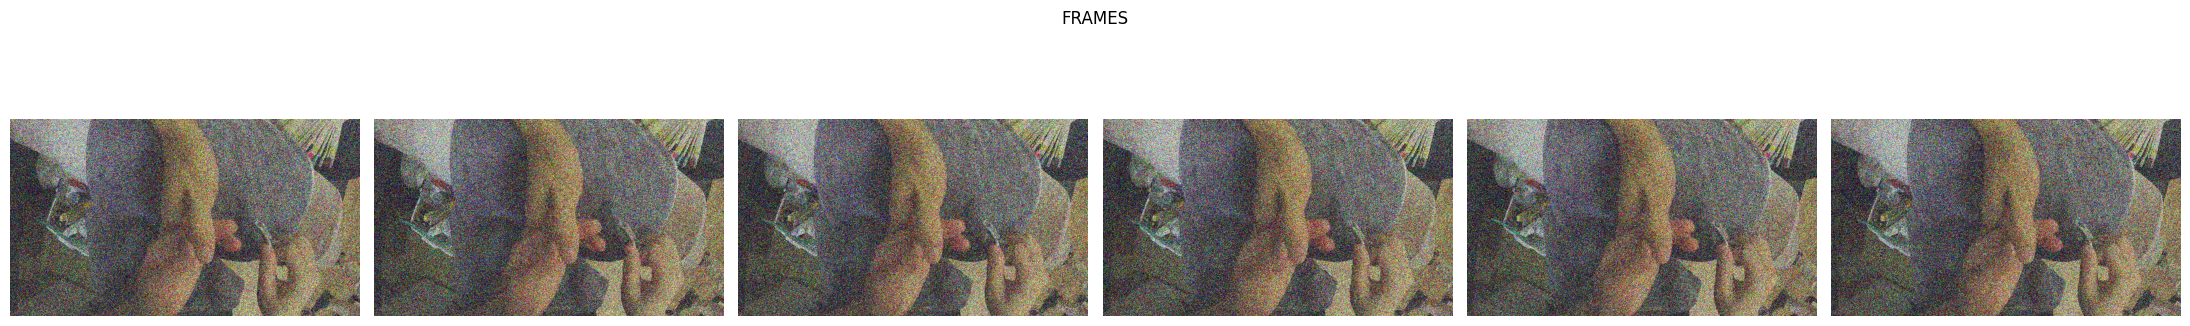

Vanilla VQA probs:
Is the brush on the wall?
{<VQAResponse.No: 0>: 0.46879065, <VQAResponse.Yes: 1>: 0.5312094}

Is the brush in someone's hand?
{<VQAResponse.No: 0>: 0.18476751, <VQAResponse.Yes: 1>: 0.8152325}

Do you see a brush in the image?
{<VQAResponse.No: 0>: 0.50781184, <VQAResponse.Yes: 1>: 0.4921881}

Do you see a wall in the image?
{<VQAResponse.No: 0>: 0.5851011, <VQAResponse.Yes: 1>: 0.41489884}

The instructions say to "Rub the brush on the wall". Do you see someone working on this?
{<VQAResponse.No: 0>: 0.31405056, <VQAResponse.Yes: 1>: 0.6859495}

The instructions say to "Rub the clippers on the towel". Do you see someone working on this?
{<VQAResponse.No: 0>: 0.019271135, <VQAResponse.Yes: 1>: 0.9807288}


Distorted/filtered VQA probs:
Is the brush on the wall?
{<VQAResponse.No: 0>: 0.61508787, <VQAResponse.Yes: 1>: 0.38491216}

Is the brush in someone's hand?
{<VQAResponse.No: 0>: 0.18476751, <VQAResponse.Yes: 1>: 0.8152325}

Do you see a brush in the image?
{<VQARes

In [33]:
import matplotlib.pyplot as plt

def display_vqg_results(frames, questions, result, result_distorted_filtered=None, combine_results_alpha=1.0):
    # Assuming new_frames is a list of image data
    fig, axarr = plt.subplots(1, len(frames), figsize=(22, 4))
    fig.suptitle("FRAMES")

    # Ensure axarr is always iterable
    if len(frames) == 1:
        axarr = [axarr]

    for frame, ax in zip(frames, axarr):
        if frame is not None:
            ax.imshow(frame)
            ax.axis('off')  # Hide the axes for better visualization

    plt.tight_layout()
    plt.show()

    print("Vanilla VQA probs:")
    for q, r in zip(questions, result):
        print(q)
        pprint(r.answer_probs)
        print("")
    
    if result_distorted_filtered is not None:
        print("\nDistorted/filtered VQA probs:")
        for q, r in zip(questions, result_distorted_filtered):
            print(q)
            pprint(r.answer_probs)
            print("")
            
        print("\nCombined VQA probs:")
        for q, r0, r1 in zip(questions, result, result_distorted_filtered):
            logits_r0 = r0.logits
            logits_r1 = r1.logits
            
            logits_combined = (1 + combine_results_alpha) * logits_r0 - combine_results_alpha * logits_r1
            output_combined = VQAOutputs(task_name=MistakeDetectionTasks.Ego4D, example_id="", procedure_id=0, frame="", prompt="", expected_answer=VQAResponse.No, response_token_ids=response_token_ids, logits=logits_combined)
            
            print(q)
            pprint(output_combined.answer_probs)
            print("")
    
if visual_filter is not None:
    result_distorted_filtered = result_filter
    frames_to_display = frames_filter
elif frames_distorted is not None:
    result_distorted_filtered = result_distorted
    frames_to_display = frames_distorted
else:
    result_distorted_filtered = None
    frames_to_display = frames
display_vqg_results(frames_to_display, questions, result, result_distorted_filtered=result_distorted_filtered, combine_results_alpha=1.0)

# Run image captioning

In [32]:
from PIL import Image

from travel.data.vqa import COMPLETION_PROMPT_TEMPLATES, get_vqa_response_token_ids

frames = [
    # Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition4of4/1ab9d5f7-0181-458e-a5e7-72ce87501f3e/38/pos/frames/frame_1ab9d5f7-0181-458e-a5e7-72ce87501f3e-38-pos_0.jpg"),
    Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition3of4/da32ff6e-27b2-47e6-b38f-dbf7a36b5f4d/70/easyneg_MisalignSRL_V_ARG1_898afb02-0bde-4fe7-81f8-645b94ac4899_4034.461679999999/frames/frame_da32ff6e-27b2-47e6-b38f-dbf7a36b5f4d-70-easyneg_MisalignSRL_V_ARG1_898afb02-0bde-4fe7-81f8-645b94ac4899_4034.461679999999_3.jpg"),
    Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition1of4/79c62f24-488e-4a69-8220-3b20cb4bf72b/398/easyneg_MisalignSRL_V_ARG1_c8f8ebf1-5613-4f4a-802c-ada5e4c4b651_326.6214286/frames/frame_79c62f24-488e-4a69-8220-3b20cb4bf72b-398-easyneg_MisalignSRL_V_ARG1_c8f8ebf1-5613-4f4a-802c-ada5e4c4b651_326.6214286_3.jpg"),    
    Image.open("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_cache_dir/ego4d_val_seed222_mismatch_multiframe_partition1of4/5b97f47f-f015-46f3-8879-3fcc2a61a728/177/easyneg_MisalignSRL_ARG1_2dbdd409-0be0-447c-8ae8-3f107fe9af80_152.6393286/frames/frame_5b97f47f-f015-46f3-8879-3fcc2a61a728-177-easyneg_MisalignSRL_ARG1_2dbdd409-0be0-447c-8ae8-3f107fe9af80_152.6393286_1.jpg"),
]

prompts = [COMPLETION_PROMPT_TEMPLATES[type(vlm)] for _ in frames]

response_token_ids = get_vqa_response_token_ids(vlm_processor.tokenizer)

candidate_procedures = [
    # ["Open up the avocado", "Open the cabinet", "Open the tap"],
    ["Take the glue tube from the drawer", "Hammer the floorboard"],
    ["Cut the meat", "Pick up the thread"],
    ["Trim the nails", "Rub the clippers on the towel", "Rub the brush on the wall", "Paint the wall with the paint brush"],
]

followup_questions = [
    ["Is there a glue tube in the image?", "Is the glue tube in the drawer?", "Is the glue tube in someone's hand?", "Are the floorboards connected?", "Is the person using a hammer?"],
    ["Is there a thread in the image?", "Is the thread in someone's hand?", "Is the thread in the bag?", "Is the meat cut?", "Is there a knife in someone's hand?"],
    ["Is there a brush in the image?", "Is the brush on the wall?", "Is the brush being held by someone?", "Are the clippers being held?", "Are the clippers touching the towel?"],
]

In [ ]:
inputs = vlm_processor(text=prompts, images=frames, return_tensors="pt", padding=True).to(vlm.device)

generated_ids = vlm.generate(**inputs, max_length=256)
captions = vlm_processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)        

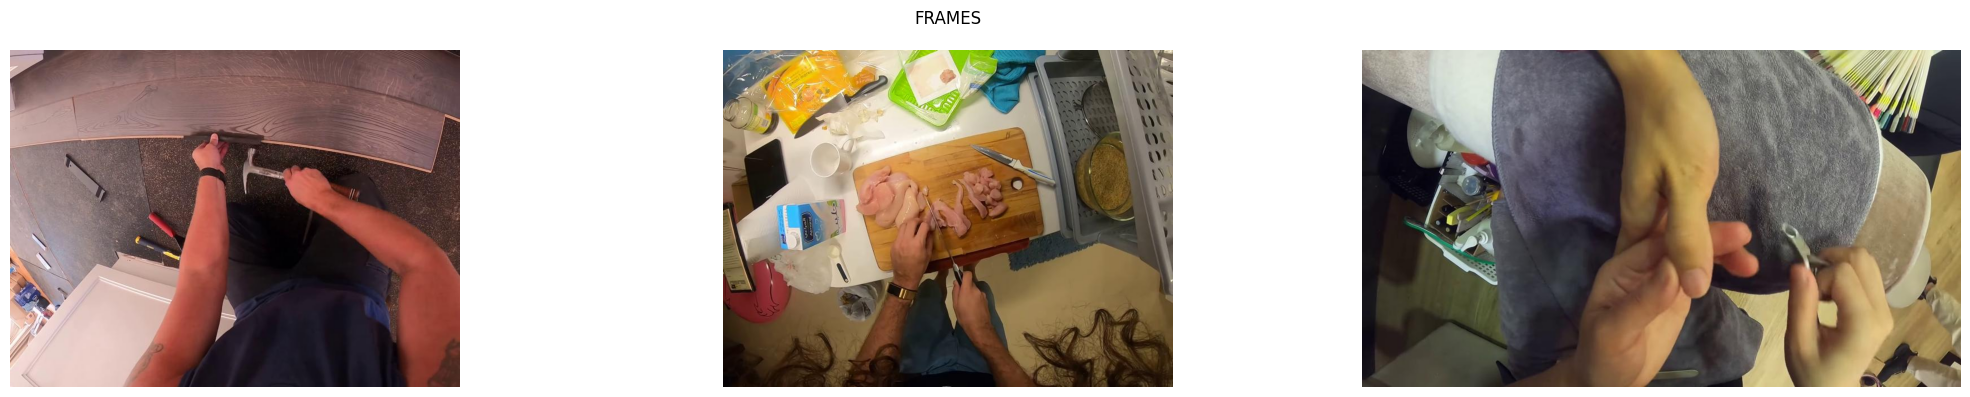

USER:  
What is happening in this photo? 
ASSISTANT: This is a photo of a man working on a wooden floor, possibly in a garage or workshop. He is using a hammer to fix or install a wooden floor, and he is wearing a wristwatch. The man is focused on his task, and the image captures the moment of him using the hammer to complete the job.

USER:  
What is happening in this photo? 
ASSISTANT: This is a photo of a person preparing food on a cutting board. The person is cutting up chicken, and there are several pieces of chicken spread across the cutting board. The scene also includes a knife, a cup, and a bowl, which are likely used for the food preparation process. The person is focused on their task, and the overall atmosphere suggests a home kitchen setting.

USER:  
What is happening in this photo? 
ASSISTANT: This is a photo of a person's hand, which is being held by another person. The person holding the hand is using a pair of scissors to cut the person's fingernails. The scene takes 

In [ ]:
import matplotlib.pyplot as plt
from pprint import pprint

# Assuming new_frames is a list of image data
fig, axarr = plt.subplots(1, len(frames), figsize=(22, 4))
fig.suptitle("FRAMES")

# Ensure axarr is always iterable
if len(frames) == 1:
    axarr = [axarr]

for frame, ax in zip(frames, axarr):
    if frame is not None:
        ax.imshow(frame)
        ax.axis('off')  # Hide the axes for better visualization

plt.tight_layout()
plt.show()

for caption in captions:
    print(caption.replace("ASSISTANT:", "\nASSISTANT:"))  
    print("")

In [36]:
from pprint import pprint

from travel.data.mistake_detection import MistakeDetectionTasks
from travel.data.vqa import VQAOutputs, VQAResponse
from travel.model.vqa import run_vqa

prompts = [caption.replace("USER:", "USER: <image>\n") + " " + f"USER: {question} ASSISTANT: "  for prompt, caption, questions in zip(prompts, captions, followup_questions) for question in questions]
frames = [frame for frame, procedures in zip(frames, followup_questions) for _ in procedures]

result = run_vqa(vlm, vlm_processor, prompts, frames, batch_size=10)
result = [VQAOutputs(task_name=MistakeDetectionTasks.Ego4D, example_id="", procedure_id=0, frame="", prompt="", expected_answer=VQAResponse.No, response_token_ids=response_token_ids, logits=result[i]) for i in range(result.shape[0])]

running VQA (cuda:0): 100%|██████████| 2/2 [00:05<00:00,  2.86s/it]


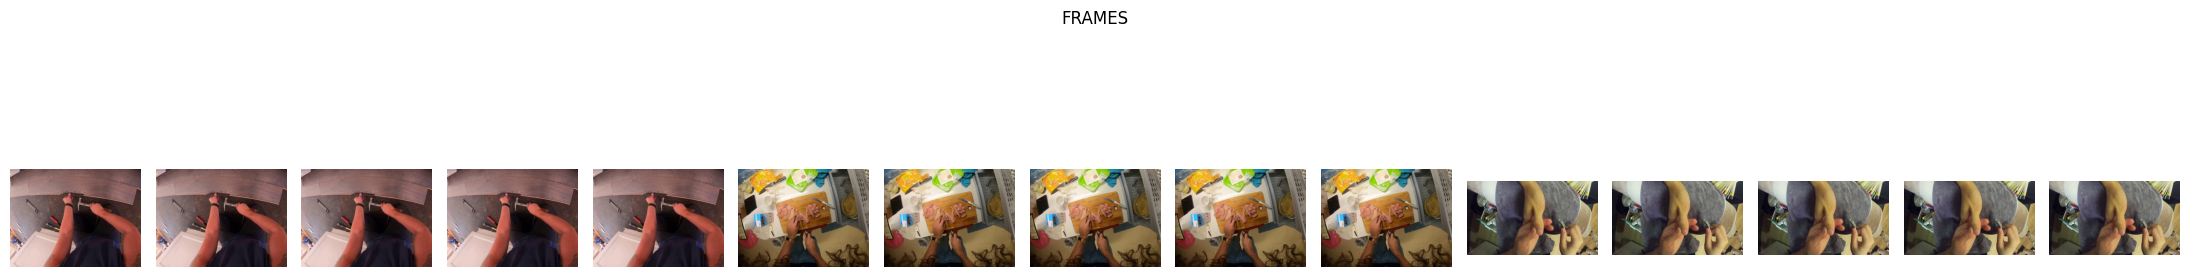

USER: <image>
  
What is happening in this photo? 
ASSISTANT: This is a photo of a man working on a wooden floor, possibly in a garage or workshop. He is using a hammer to fix or install a wooden floor, and he is wearing a wristwatch. The man is focused on his task, and the image captures the moment of him using the hammer to complete the job. USER: Is there a glue tube in the image? 
ASSISTANT: 
{<VQAResponse.No: 0>: 0.26435834, <VQAResponse.Yes: 1>: 0.7356416}

USER: <image>
  
What is happening in this photo? 
ASSISTANT: This is a photo of a man working on a wooden floor, possibly in a garage or workshop. He is using a hammer to fix or install a wooden floor, and he is wearing a wristwatch. The man is focused on his task, and the image captures the moment of him using the hammer to complete the job. USER: Is the glue tube in the drawer? 
ASSISTANT: 
{<VQAResponse.No: 0>: 0.43974736, <VQAResponse.Yes: 1>: 0.56025267}

USER: <image>
  
What is happening in this photo? 
ASSISTANT: This

In [37]:
import matplotlib.pyplot as plt
from pprint import pprint

# Assuming new_frames is a list of image data
fig, axarr = plt.subplots(1, len(frames), figsize=(22, 4))
fig.suptitle("FRAMES")

# Ensure axarr is always iterable
if len(frames) == 1:
    axarr = [axarr]

for frame, ax in zip(frames, axarr):
    if frame is not None:
        ax.imshow(frame)
        ax.axis('off')  # Hide the axes for better visualization

plt.tight_layout()
plt.show()

for p, r in zip(prompts, result):
    print(p.replace("ASSISTANT:", "\nASSISTANT:"))  
    pprint(r.answer_probs)
    print("")

Use NLI model to judge captions:

In [22]:
from transformers import pipeline, BitsAndBytesConfig, AutoModelForSequenceClassification, AutoTokenizer

from travel.model.mistake_detection import NLI_MODEL_PATH

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    llm_int8_threshold=6.0,
    llm_int8_has_fp16_weight=False,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
)
nli_model = AutoModelForSequenceClassification.from_pretrained(NLI_MODEL_PATH, quantization_config=bnb_config)
nli_tokenizer = AutoTokenizer.from_pretrained(NLI_MODEL_PATH)

/home/sstorks/.cache/pypoetry/virtualenvs/travel-nQET-zRt-py3.10/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
`low_cpu_mem_usage` was None, now set to True since model is quantized.


In [53]:
premises = [caption.split("ASSISTANT:")[1].strip() for caption, procedures in zip(captions, candidate_procedures) for procedure in procedures]
hypotheses = [f"The person is going to {procedure[0].lower() + procedure[1:]}" for caption, procedures in zip(captions, candidate_procedures) for procedure in procedures]

x = nli_tokenizer.batch_encode_plus(list(zip(premises, hypotheses)), 
                                        return_tensors='pt',
                                        padding="longest",
                                        truncation='only_first')
logits = nli_model(**x.to(nli_model.device))[0]
logits = logits.cpu()
logits = logits[:,[0, 2]] # Take logits for contradiction and entailment only
probs = logits.softmax(dim=1).detach().numpy()
probs = probs[:, 1]


In [54]:
for p, h, prob in zip(premises, hypotheses, probs):
    print(f"Premise: {p}")
    print(f"Hypothesis: {h}")
    print(f"Probability (entailment): {prob}")
    print("")

Premise: This is a photo of a person standing in a kitchen, preparing a meal. The person is cutting lettuce in a sink, using a knife to chop the vegetables. The kitchen is equipped with a stove, a refrigerator, and a microwave. There are also a couple of cups and a bowl placed around the kitchen. The scene captures the person's focus on preparing the meal, showcasing the process of food preparation in a home kitchen setting
Hypothesis: The person is going to open up the avocado
Probability (entailment): 0.3427734375

Premise: This is a photo of a person standing in a kitchen, preparing a meal. The person is cutting lettuce in a sink, using a knife to chop the vegetables. The kitchen is equipped with a stove, a refrigerator, and a microwave. There are also a couple of cups and a bowl placed around the kitchen. The scene captures the person's focus on preparing the meal, showcasing the process of food preparation in a home kitchen setting
Hypothesis: The person is going to open the cabin